# Neural Basis Models for Interpretable ML

The is an implementation of Neural Basis Models - an interpretable model. 

Reference: [Radenovic, F., Dubey, A., & Mahajan, D. (2022). Neural basis models for interpretability. Advances in Neural Information Processing Systems, 35, 8414-8426.](https://scontent.fyzd1-3.fna.fbcdn.net/v/t39.2365-6/314337643_868019464189734_6788216842989586637_n.pdf?_nc_cat=105&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=Wj2-XSf3f7AQ7kNvgGGqQ1i&_nc_oc=Adh4aigsfDkTXVb1Y9PgVZsK-VAHW-nBHry5vyDuf96-zsuAU81E4uSPhskXrHjr-mJeiLzGZdSpae-2FAU_6Ae8&_nc_zt=14&_nc_ht=scontent.fyzd1-3.fna&_nc_gid=ADB97XsmBp87uI-wT24eoTX&oh=00_AYGx01Jaf9HOEYMbyAo0_lyAAAyfi9E6ZGhtd64gctCpgw&oe=67D95232)

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from model.nbm_model import ConceptNBMNary
from utils.plot_shapefunc import plot_nbm_shape_functions_with_feature_density, permutation_importance, plot_feature_importance
from tqdm import tqdm

# fix random seeds for reproducibility
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## **1.Dataset Loading, Preprocessing and Dataloader Instantiation**

We will perform a regression problem using the California Housing Dataset to predict house prices.


In [3]:
# Load California Housing dataset
data = fetch_california_housing()
X = data.data  # features
y = data.target  # target (continuous)

# Apply MinMax scaling to the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape: [N, 1]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader objects for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


## **2.Set up the NBM model and hyperparameters**

In [4]:
# Define the model hyperparameters
num_concepts = X_train_tensor.shape[1]  # number of features (8 for California Housing)
num_classes = 1  # regression output is a single continuous value
num_bases = 100
hidden_dims = (256, 128, 128)
num_subnets = 1
dropout = 0.0
bases_dropout = 0.2
batchnorm = True

# Instantiate the model (nary is left as None so that it uses all unary interactions)
model = ConceptNBMNary(
    num_concepts=num_concepts,
    num_classes=num_classes,
    nary=None,
    num_bases=num_bases,
    hidden_dims=hidden_dims,
    num_subnets=num_subnets,
    dropout=dropout,
    bases_dropout=bases_dropout,
    batchnorm=batchnorm
)

# Use Mean Squared Error for regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


## **3. Training and Validation**

In [5]:
# Train the model
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        optimizer.zero_grad()
        # In training mode, the model returns a tuple: (output, features)
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

# test the model
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for inputs, targets in tqdm(test_loader, desc="Testing", leave=False):
        # In eval mode, the model returns only the output
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
    test_loss = total_loss / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}") 
print(f"RMSE: {test_loss**0.5:.4f}")    

Epoch 1/50 - Loss: 0.8240


Epoch 2/50 - Loss: 0.5362


Epoch 3/50 - Loss: 0.5035


Epoch 4/50 - Loss: 0.4855


Epoch 5/50 - Loss: 0.4813


Epoch 6/50 - Loss: 0.4796


Epoch 7/50 - Loss: 0.4734


Epoch 8/50 - Loss: 0.4701


Epoch 9/50 - Loss: 0.4669


Epoch 10/50 - Loss: 0.4644


Epoch 11/50 - Loss: 0.4632


Epoch 12/50 - Loss: 0.4633


Epoch 13/50 - Loss: 0.4568


Epoch 14/50 - Loss: 0.4611


Epoch 15/50 - Loss: 0.4554


Epoch 16/50 - Loss: 0.4560


Epoch 17/50 - Loss: 0.4541


Epoch 18/50 - Loss: 0.4518


Epoch 19/50 - Loss: 0.4492


Epoch 20/50 - Loss: 0.4452


Epoch 21/50 - Loss: 0.4433


Epoch 22/50 - Loss: 0.4437


Epoch 23/50 - Loss: 0.4457


Epoch 24/50 - Loss: 0.4430


Epoch 25/50 - Loss: 0.4441


Epoch 26/50 - Loss: 0.4451


Epoch 27/50 - Loss: 0.4353


Epoch 28/50 - Loss: 0.4376


Epoch 29/50 - Loss: 0.4349


Epoch 30/50 - Loss: 0.4320


Epoch 31/50 - Loss: 0.4481


Epoch 32/50 - Loss: 0.4359


Epoch 33/50 - Loss: 0.4381


Epoch 34/50 - Loss: 0.4313


Epoch 35/50 - Loss: 0.4296


Epoch 36/50 - Loss: 0.4233


Epoch 37/50 - Loss: 0.4260


Epoch 38/50 - Loss: 0.4253


Epoch 39/50 - Loss: 0.4236


Epoch 40/50 - Loss: 0.4201


Epoch 41/50 - Loss: 0.4195


Epoch 42/50 - Loss: 0.4260


Epoch 43/50 - Loss: 0.4221


Epoch 44/50 - Loss: 0.4126


Epoch 45/50 - Loss: 0.4204


Epoch 46/50 - Loss: 0.4148


Epoch 47/50 - Loss: 0.4143


Epoch 48/50 - Loss: 0.4144


Epoch 49/50 - Loss: 0.4164


Epoch 50/50 - Loss: 0.4197


Test Loss: 0.4978
RMSE: 0.7056


## **4. Plot the shape functions for the model**

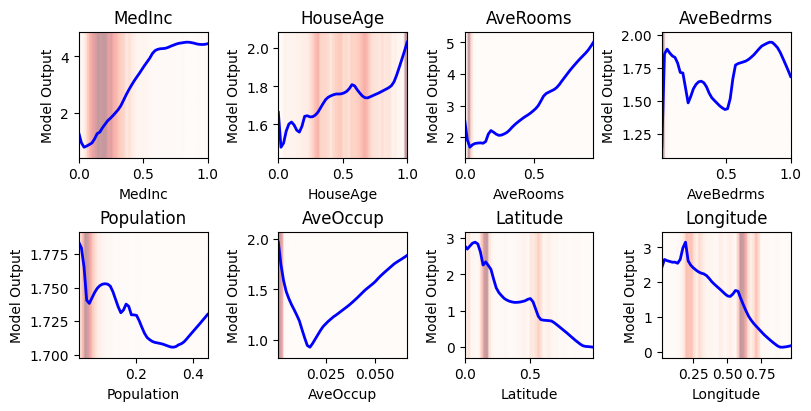

In [6]:

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model.eval()
model.to(device)

feature_names = [
    "MedInc", "HouseAge", "AveRooms", "AveBedrms", 
    "Population", "AveOccup", "Latitude", "Longitude"
]

plot_nbm_shape_functions_with_feature_density(
    model,
    X_test, 
    feature_names=feature_names,
    n_points=50,   # more points for a smoother curve
    bins=50,        # more histogram bins
    device=device,
    plot_cols=4,
    red_alpha=0.4
)

## **5. Intepretation of Model's Prediction**

<p align="center">
<img src="california-lat-long-map.jpg" alt="California map" width="500"/>
</p>


**General Observations**
1.	**MedInc (Median Income)**
	-	The partial dependence rises from left to right, indicating that higher median income regions lead to higher predicted house values.
	-	This is domain-consistent, as wealthier areas typically have higher housing prices.
	-	The red shading suggests most data is clustered in the middle range of MedInc.

2.	**HouseAge**
	-	The model’s prediction increases with scaled HouseAge.
	-	One possible explanation: older houses might be located in more established (and thus pricier) neighborhoods, or HouseAge correlates with desirable locations.
		Alternatively, this could reflect some location confound (e.g., older houses near the coast).
3.	**AveRooms (Average Number of Rooms)**
	-	Falling Slope in Dense Region
		-	In the middle range (where the red shading is relatively dark), the partial dependence slopes downwards.
		-	This suggests that, on average, increasing “AveRooms” (in that typical range) lowers predicted house value—or at least doesn’t raise it.
		-	One possible explanation is that very high “AveRooms” in middle‐density data might correlate with older or more rural neighborhoods, or perhaps large but less desirable houses.
	-	Rapid Rise in Sparse Region
		-	Far to the right (or left) where the feature values are less common (light red), the curve shoots up.
		-	Because the model sees few examples there, it might be driven by a small cluster of high‐end properties (or outliers) that happen to have many rooms.
		-	Alternatively, it could be partial overfitting in that region.

5.	**Population**
	-	The model’s output peaks somewhere in the middle of the population range, then drops for very high or very low population values.
	-	This can reflect that extremely dense or sparsely populated areas might be less valuable (or have different socio-economic contexts) than moderately populated neighborhoods.

6.	**AveOccup (Average Occupancy)**
	-	Dip in the Densest Range
		- The partial dependence shows a downward trend across the typical occupancy range, implying that as “AveOccup” rises within that dense interval, the model predicts lower values.
		- This could indicate that moderate occupancy is more typical of higher‐value areas, whereas higher occupancy might correlate with overcrowded or less expensive neighborhoods.
	-	Sharp Increase Beyond Sparse Range
		-	Past a certain occupancy level (where the data is sparse), the model’s predictions jump.
		-	Possibly, this is triggered by a small set of neighborhoods with very high occupancy that also have high prices (for instance, certain unique urban areas) or it might be extrapolation.

7.	**Latitude**
	-	A generally descending trend from left to right in your scaled axis.
	-	Interpreted literally: as latitude increases (moving north in California), the predicted house value (on average) decreases.
	-	This might reflect that southern coastal areas (Los Angeles, Orange County, San Diego) are often quite expensive.
	-	In raw coordinates, CA latitudes range from about 32.5° (south) to 42° (north).
	
8.	**Longitude**
	-	Also sloping downward overall.
	-	Typically, in raw data, more westerly longitudes (coastal regions) can be more expensive (like the Bay Area near -122 or coastal LA near -118).
	-	Moving inland (higher or lower scaled longitude) often correlates with lower prices.

## **6. Global Feature Importance**

One way to obtain global feature importance for this model is to apply Permutation-based Importance method. 

**How Permutation Importance Works**

1. **Baseline Performance:** First, measure model’s performance (e.g., MSE, $R^2$) on the original dataset.
2. **Shuffle Each Feature:** For each feature $j$:
   - Shuffle the values in that feature’s column (breaking any relationship with the target).
   - Re-compute the performance on this modified dataset.
   - The drop in performance (compared to baseline) indicates how important feature $j$ is to the model.
3. **Repeat & Average:** Do multiple shuffles (repeats) per feature and average the performance drops to get a more stable estimate.
4. **Plot:** Show a bar chart of the average performance drop for each feature, sorted from most to least important.

In [ ]:
importances, importances_std = permutation_importance(
    model,
    X_test,
    y_test,
    metric=mean_squared_error,
    n_repeats=3,
    random_state=42
)

plot_feature_importance(importances, importances_std, feature_names=feature_names)

NameError: name 'permutation_importance' is not defined